# 1. Tratamento dos dados

## 1.1 - Imports

In [2]:
# Processamento
import pandas as pd # bibilioteca de engenharia de dados
import numpy as np # biblioteca de expressões algébricas
from sklearn.preprocessing import MinMaxScaler

# Redes Neurais Algoritimicas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Métricas
from sklearn.metrics import mean_squared_error

# Visualização
import matplotlib.pyplot as plt   # Biblioteca para criar gráficos, usada para exibir a matriz de confusão

## 1.2 - Carregando o dataset

In [3]:
df = pd.read_csv("br_mme_consumo_energia_eletrica_uf.csv")
df = df.sort_values(by=['ano', 'mes'])
df

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624
...,...,...,...,...,...,...
38875,2023,12,BA,Residencial,5932740.0,718461
38876,2023,12,PA,Residencial,2614106.0,478726
38877,2023,12,AC,Residencial,245699.0,58301
38878,2023,12,RN,Residencial,1390080.0,210119


# 2. Pré-processamento dos Dados

In [4]:
# Função para obter estação do ano
def get_season(month):
    if month in [12, 1, 2]:  # Verão
        return 'verao'
    elif month in [3, 4, 5]:  # Outono
        return 'outono'
    elif month in [6, 7, 8]:  # Inverno
        return 'inverno'
    else:  # Primavera
        return 'primavera'

# Criar variáveis de lag
df['lag_1'] = df.groupby('sigla_uf')['consumo'].shift(1)  # Consumo do mês anterior
df['lag_3'] = df.groupby('sigla_uf')['consumo'].shift(3)  # Consumo de 3 meses atrás
df['lag_12'] = df.groupby('sigla_uf')['consumo'].shift(12)  # Consumo de 12 meses atrás

# Imputar valores nulos em 'numero_consumidores' com a mediana por 'sigla_uf'
df['numero_consumidores'] = df.groupby('sigla_uf')['numero_consumidores'].transform(lambda x: x.fillna(x.median()))

# Imputar valores nulos em 'consumo' com a mediana por 'sigla_uf'
df['consumo'] = df.groupby('sigla_uf')['consumo'].transform(lambda x: x.fillna(x.median()))

# Aplicar transformação logarítmica no 'consumo'
df['log_consumo'] = np.log1p(df['consumo'])  # log(1 + consumo)

# Agrupar os dados por ano, mês, sigla_uf e tipo_consumo
df_brasil = df.groupby(['ano', 'mes']).agg({'consumo': 'sum',
                                            'numero_consumidores': 'sum',
                                            'lag_1': 'sum',
                                            'lag_3': 'sum',
                                            'lag_12': 'sum',
                                            'log_consumo': 'sum'}).reset_index()

# Criar a variável 'estacao' para sazonalidade
df_brasil['estacao'] = df_brasil['mes'].apply(get_season)

# Encoding das estações
df_encoded = pd.get_dummies(df_brasil, columns=['estacao']).replace({True: 1, False: 0})

# Normalização das variáveis numéricas
scaler = MinMaxScaler()
df_encoded[['consumo', 'numero_consumidores', 'lag_1', 'lag_3', 'lag_12', 'log_consumo']] = scaler.fit_transform(df_encoded[['consumo', 'numero_consumidores', 'lag_1', 'lag_3', 'lag_12', 'log_consumo']])

df_encoded.head()

<ipython-input-4-b704d430d432>:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = pd.get_dummies(df_brasil, columns=['estacao']).replace({True: 1, False: 0})


,ano,mes,consumo,numero_consumidores,lag_1,lag_3,lag_12,log_consumo,estacao_inverno,estacao_outono,estacao_primavera,estacao_verao
0,2004,1,0.028259,0.000000,0.000000,0.000000,0.000000,0.082414,0,0,0,1
1,2004,2,0.000000,0.005819,0.113022,0.325787,0.000000,0.000000,0,0,0,1
2,2004,3,0.045774,0.010672,0.144236,0.342317,0.654049,0.070669,0,1,0,0
3,2004,4,0.091473,0.015324,0.184804,0.373210,0.643022,0.106524,0,1,0,0
4,2004,5,0.037501,0.012966,0.146527,0.357654,0.660884,0.067839,0,1,0,0


# 3. Construindo o Modelo

In [6]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])  # Dados dos últimos 12 meses
        y.append(data[i][2])  # Consumo atual como o target
    return np.array(X), np.array(y)

data = df_encoded[df_encoded.columns].dropna().values

# Definindo a quantidade de passos (12 meses anteriores)
n_steps = 12
X, y = create_sequences(data, n_steps)

# Exibindo as dimensões dos dados para o LSTM
print("Formato de X (entrada para LSTM):", X.shape)  # Esperado: (n amostras, 12, 2)
print("Formato de y (target):", y.shape)  # Esperado: (n amostras,)

# Dividindo os dados em treinamento e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construindo o modelo LSTM ajustado
model = Sequential()
model.add(LSTM(32,
               return_sequences=True,
               input_shape=(n_steps, X.shape[2]),
               kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(16,
               return_sequences=False,
               kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Formato de X (entrada para LSTM): (228, 12, 12)
Formato de y (target): (228,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 12, 32)              │           5,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,913 (34.82 KB)

 Trainable params: 8,913 (34.82 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Treinamento

In [7]:
# Treinando o modelo
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.8460 - mae: 0.3880 - val_loss: 0.6170 - val_mae: 0.1377
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6752 - mae: 0.2434 - val_loss: 0.6091 - val_mae: 0.2206
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6154 - mae: 0.2239 - val_loss: 0.6075 - val_mae: 0.2874
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5932 - mae: 0.2512 - val_loss: 0.5618 - val_mae: 0.2717
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5576 - mae: 0.2537 - val_loss: 0.5262 - val_mae: 0.2685
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5025 - mae: 0.2141 - val_loss: 0.5049 - val_mae: 0.2856
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4680 - mae: 0.2131 - val_loss: 0.4598 - val_mae: 0.2588
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4493 - mae: 0.2303 - val_loss: 0.4241 - val_mae: 0.2428
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4165 - mae: 0.2171 -

# 5. Avaliação do Modelo

In [8]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Perda (MSE): {loss}, Erro Absoluto Médio (MAE): {mae}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0951 - mae: 0.2399 
Perda (MSE): 0.10244282335042953, Erro Absoluto Médio (MAE): 0.25303488969802856


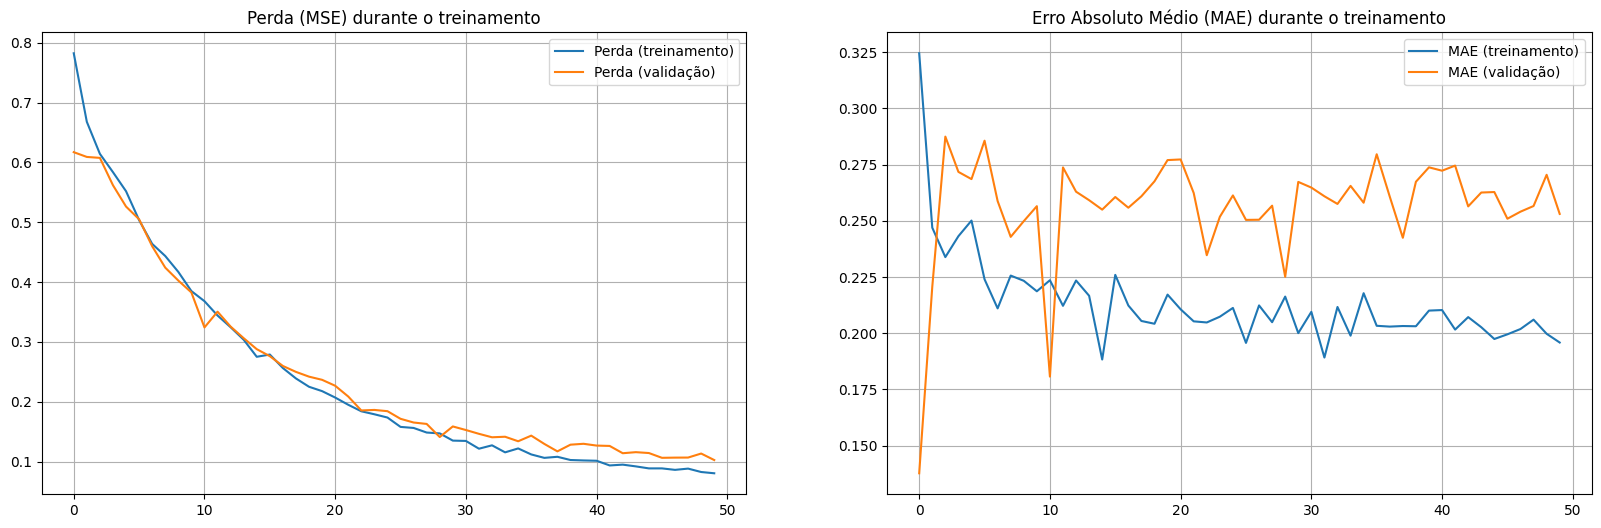

In [9]:
# Plotando a perda e o MAE durante o treinamento
plt.figure(figsize=(20, 6))

# Gráfico de perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda (treinamento)')
plt.plot(history.history['val_loss'], label='Perda (validação)')
plt.title('Perda (MSE) durante o treinamento')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (treinamento)')
plt.plot(history.history['val_mae'], label='MAE (validação)')
plt.title('Erro Absoluto Médio (MAE) durante o treinamento')
plt.legend()
plt.grid(True)

plt.show()

# 6. Previsão para os Próximos 12 Meses

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
RMSE: 12809331.292269368


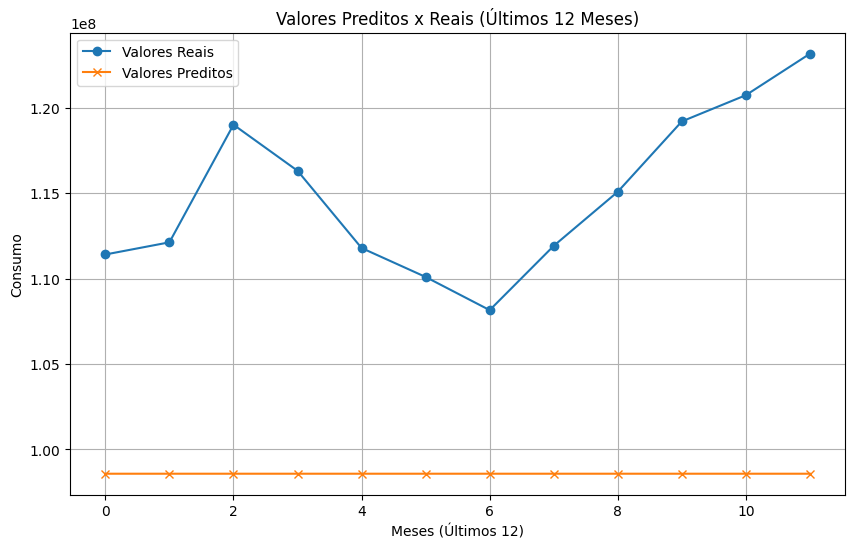

In [10]:
# Fazendo previsões
y_pred = model.predict(X_test)

# Revertendo a normalização para as previsões
y_pred_rescaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((y_pred.shape[0], 5))]))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 5))]))[:, 0]

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print("RMSE:", rmse)

# Pegando os últimos 12 meses
y_pred_last_12 = y_pred_rescaled[-12:]
y_test_last_12 = y_test_rescaled[-12:]

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(12), y_test_last_12, label='Valores Reais', marker='o')
plt.plot(range(12), y_pred_last_12, label='Valores Preditos', marker='x')
plt.title('Valores Preditos x Reais (Últimos 12 Meses)')
plt.xlabel('Meses (Últimos 12)')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# 7. Conclusões (Relatório)

O projeto teve como objetivo modelar o consumo de energia elétrica no Brasil ao longo do tempo, utilizando dados históricos e técnicas avançadas de aprendizado profundo com LSTMs para capturar padrões temporais e sazonais. Desde a organização inicial do dataset, passando pelo enriquecimento das variáveis com lags e transformações logarítmicas, até a construção do modelo preditivo, foi possível alcançar resultados satisfatórios.

Durante o treinamento, o modelo apresentou uma convergência significativa com a redução do erro médio absoluto (MAE) e da perda (MSE) ao longo das 50 épocas. Observou-se um desempenho estável tanto no conjunto de validação quanto no de treinamento, demonstrando a capacidade do modelo de generalizar os padrões aprendidos.

Além disso, a adição de variáveis como estações do ano e lags históricos permitiu explorar a sazonalidade e dependências temporais que são características marcantes no consumo de energia elétrica. A abordagem empregada mostrou-se eficaz, consolidando o uso de Redes Neurais Recorrentes como ferramenta robusta para análise de séries temporais com múltiplos preditores.

Assim, os resultados obtidos destacam o potencial do modelo desenvolvido para suportar a previsão de consumo energético, podendo contribuir para análises estratégicas e tomadas de decisão mais assertivas no setor energético brasileiro.